In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

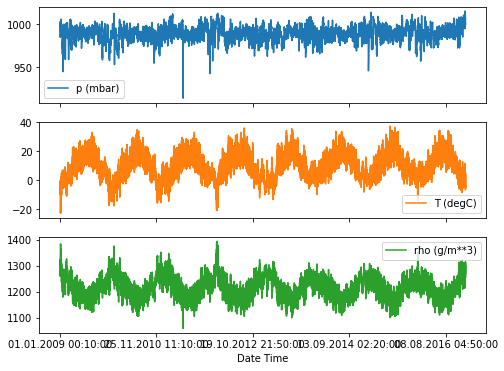

In [2]:
features.plot(subplots=True)

In [3]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [4]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# Normalization
dataset = (dataset-data_mean)/data_std

In [5]:
def multivariate_data(dataset, target, start_idx, end_idx, history_size,
                     target_size, step, single_step=False):
    data = []
    labels = []
    
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size

    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [7]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP,
                                                  single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                              TRAIN_SPLIT, None, past_history,
                                              future_target, STEP,
                                              single_step=True)

In [8]:
print('Single window of past history: {}'.format(x_train_single[0].shape))

Single window of past history: (120, 3)


In [11]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [13]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(
    32,
    input_shape=x_train_single.shape[-2:]
))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [14]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [16]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single,
                                           epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                           validation_data=val_data_single,
                                           validation_steps=50)

Epoch 1/10
200/200 [==============================] - 10s 43ms/step - loss: 0.3251 - val_loss: 0.2670
Epoch 2/10
200/200 [==============================] - 8s 41ms/step - loss: 0.2657 - val_loss: 0.2576
Epoch 3/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2620 - val_loss: 0.2510
Epoch 4/10
200/200 [==============================] - 8s 41ms/step - loss: 0.2603 - val_loss: 0.2494
Epoch 5/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2285 - val_loss: 0.2391
Epoch 6/10
200/200 [==============================] - 9s 43ms/step - loss: 0.2414 - val_loss: 0.2621
Epoch 7/10
200/200 [==============================] - 9s 43ms/step - loss: 0.2445 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 9s 43ms/step - loss: 0.2430 - val_loss: 0.2415
Epoch 9/10
200/200 [==============================] - 8s 42ms/step - loss: 0.2469 - val_loss: 0.2456
Epoch 10/10
200/200 [==============================] - 9s 43ms/step - loss: 0.2436 - val_l

In [17]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

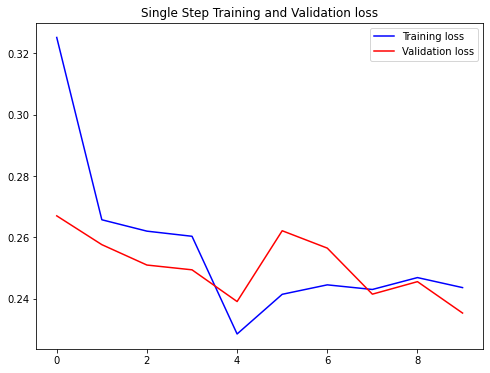

In [18]:
plot_train_history(single_step_history,
                  'Single Step Training and Validation loss')

In [22]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i],
                    label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5) * 2])
    plt.xlabel('Time-Step')
    return plt

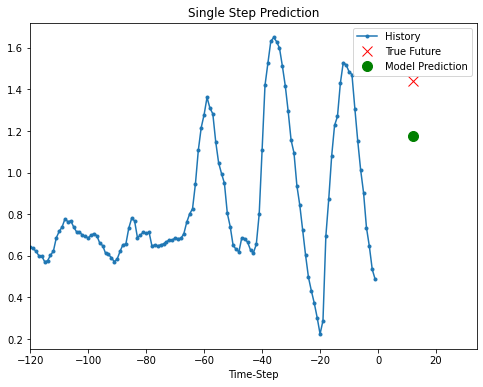

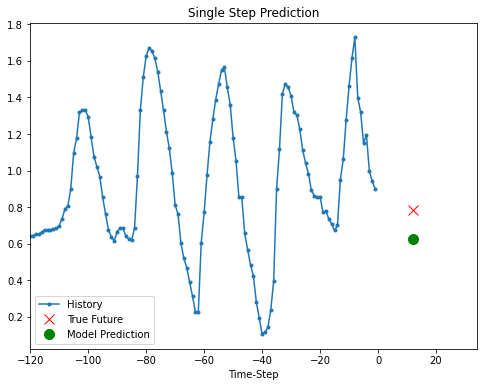

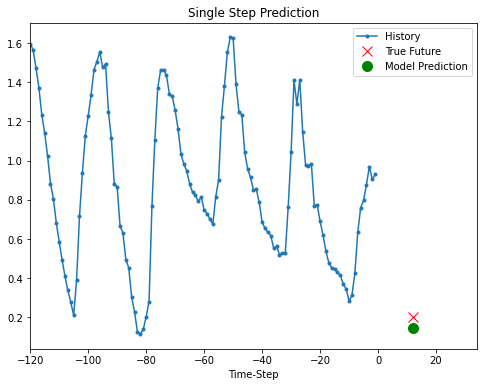

In [23]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                     single_step_model.predict(x)[0]], 12,
                    'Single Step Prediction')
    plot.show()